In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import os
import time

In [2]:
path = glob("./celeba/img_align_celeba/*.jpg")
path = path
learning_rate = 2e-4
alpha = 0.2
beta_1 = 0.5
EPOCHS = 100
BATCH_SIZE = 16
noise_dim = 100
seed = tf.random.normal([BATCH_SIZE, noise_dim])

In [3]:
def load_data(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(images=img, size=[64, 64])
    img = img / 255.0
    return img

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((path))
train_dataset = train_dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
class GEN(tf.keras.Model):
    def __init__(self):
        super(GEN, self).__init__()
        
        self.dense1 = tf.keras.layers.Dense(4*4*1024)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        self.reshape1 = tf.keras.layers.Reshape((4, 4, 1024))
        self.dec2 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=5, strides=2, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        self.dec3 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.relu3 = tf.keras.layers.ReLU()
        self.dec4 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same')
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.relu4 = tf.keras.layers.ReLU()
        self.dec5 = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=5, strides=2, padding='same', activation='tanh')
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.reshape1(x)
        x = self.dec2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dec3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dec4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dec5(x)
        return x

class DIS(tf.keras.Model):
    def __init__(self):
        super(DIS, self).__init__()
        
        self.enc1 = tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same')
        self.relu1 = tf.keras.layers.LeakyReLU(alpha=alpha)
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.enc2 = tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same')
        self.relu2 = tf.keras.layers.LeakyReLU(alpha=alpha)
        self.drop2 = tf.keras.layers.Dropout(0.3)
        self.enc3 = tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=2, padding='same')
        self.relu3 = tf.keras.layers.LeakyReLU(alpha=alpha)
        self.drop3 = tf.keras.layers.Dropout(0.3)
        self.enc4 = tf.keras.layers.Conv2D(filters=1, kernel_size=5, strides=2, padding='same', activation='sigmoid')
        
    def call(self, inputs):
        x = self.enc1(inputs)
        x = self.relu1(x)
        x = self.drop1(x)
        x = self.enc2(x)
        x = self.relu2(x)
        x = self.drop2(x)
        x = self.enc3(x)
        x = self.relu3(x)
        x = self.drop3(x)
        x = self.enc4(x)
        return x

In [6]:
G = GEN()
D = DIS()

In [7]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [8]:
def d_loss(real_img, fake_img):
    real_loss = loss(tf.ones_like(real_img), real_img)
    fake_loss = loss(tf.zeros_like(fake_img), fake_img)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
def g_loss(fake_img):
    return loss(tf.ones_like(fake_img), fake_img)

In [10]:
g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)

In [11]:
checkpoint_dir = './DCGAN/checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(g_optimizerr=g_optimizer,
                                 d_optimizer=d_optimizer,
                                 G=G,
                                 D=D)

In [12]:
@tf.function
def train_step(img):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_img = G(noise, training=True)
        
        real_img = D(img, training=True)
        fake_img = D(generated_img, training=True)
        
        gen_loss = g_loss(fake_img)
        dis_loss = d_loss(real_img, fake_img)
        
    g_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
    d_gradients = dis_tape.gradient(dis_loss, D.trainable_variables)
    
    g_optimizer.apply_gradients(zip(g_gradients, G.trainable_variables))
    d_optimizer.apply_gradients(zip(d_gradients, D.trainable_variables))

In [13]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for batch in dataset:
            train_step(batch)
        
        generate_and_save_img(G, epoch+1, seed)
            
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [14]:
def generate_and_save_img(model, epoch, test_input):
    preds = model(test_input, training=False)
    preds = preds * 255
    preds = tf.cast(preds, dtype=tf.uint8)

    fig = plt.figure(figsize=(4,4))

    for i in range(preds.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(preds[i, :, :, :])
        plt.axis('off')
    
    plt.savefig('./DCGAN/image/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    plt.close()

Time for epoch 1 is 393.7552344799042 sec
Time for epoch 2 is 391.44053053855896 sec
Time for epoch 3 is 392.05799984931946 sec
Time for epoch 4 is 391.7139992713928 sec


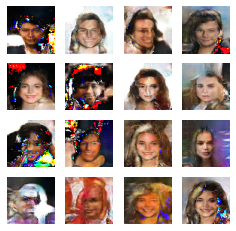

Time for epoch 5 is 392.7785646915436 sec
Time for epoch 6 is 391.10502886772156 sec
Time for epoch 7 is 390.9179973602295 sec
Time for epoch 8 is 390.61299991607666 sec
Time for epoch 9 is 390.54899978637695 sec


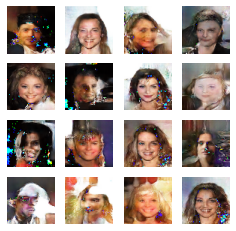

Time for epoch 10 is 391.12900400161743 sec
Time for epoch 11 is 391.42298769950867 sec
Time for epoch 12 is 391.71447825431824 sec
Time for epoch 13 is 390.84499883651733 sec
Time for epoch 14 is 391.08500027656555 sec


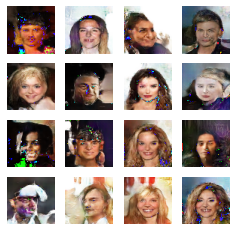

Time for epoch 15 is 391.31363821029663 sec
Time for epoch 16 is 390.3340108394623 sec
Time for epoch 17 is 390.2119994163513 sec
Time for epoch 18 is 390.74000096321106 sec
Time for epoch 19 is 390.1499993801117 sec


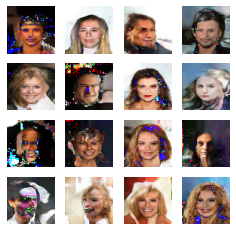

Time for epoch 20 is 390.94851565361023 sec
Time for epoch 21 is 390.2479999065399 sec
Time for epoch 22 is 390.58800053596497 sec
Time for epoch 23 is 390.3950002193451 sec
Time for epoch 24 is 390.56200075149536 sec


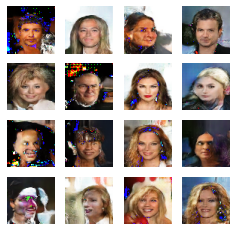

Time for epoch 25 is 395.9996507167816 sec
Time for epoch 26 is 391.6361653804779 sec
Time for epoch 27 is 391.5720000267029 sec
Time for epoch 28 is 392.1020007133484 sec
Time for epoch 29 is 391.5260000228882 sec


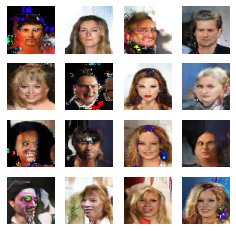

Time for epoch 30 is 392.39901399612427 sec
Time for epoch 31 is 391.7179992198944 sec
Time for epoch 32 is 392.9340007305145 sec
Time for epoch 33 is 392.1800003051758 sec
Time for epoch 34 is 392.1769995689392 sec


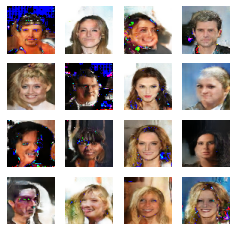

Time for epoch 35 is 393.70093989372253 sec
Time for epoch 36 is 392.8489990234375 sec
Time for epoch 37 is 392.71300053596497 sec
Time for epoch 38 is 392.57299971580505 sec
Time for epoch 39 is 392.9110014438629 sec


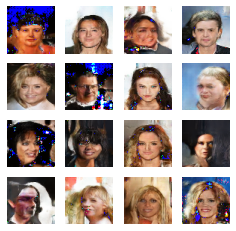

Time for epoch 40 is 393.4437463283539 sec
Time for epoch 41 is 392.481999874115 sec
Time for epoch 42 is 392.31899976730347 sec
Time for epoch 43 is 392.1930003166199 sec
Time for epoch 44 is 392.33000135421753 sec


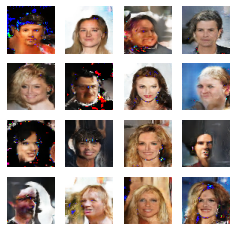

Time for epoch 45 is 393.04491424560547 sec
Time for epoch 46 is 392.70999932289124 sec
Time for epoch 47 is 392.3019983768463 sec
Time for epoch 48 is 393.2564845085144 sec
Time for epoch 49 is 393.34000158309937 sec


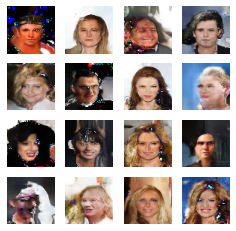

Time for epoch 50 is 394.18587589263916 sec
Time for epoch 51 is 392.8300006389618 sec
Time for epoch 52 is 393.30099844932556 sec
Time for epoch 53 is 393.8150029182434 sec
Time for epoch 54 is 393.77099800109863 sec


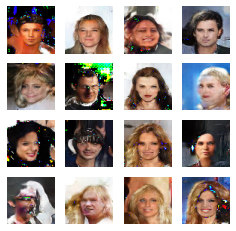

Time for epoch 55 is 393.8823344707489 sec
Time for epoch 56 is 392.525997877121 sec
Time for epoch 57 is 392.5280005931854 sec
Time for epoch 58 is 392.38399934768677 sec
Time for epoch 59 is 392.1960029602051 sec


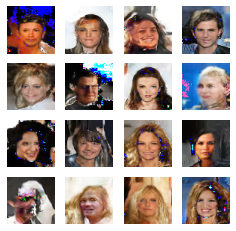

Time for epoch 60 is 393.36690163612366 sec
Time for epoch 61 is 392.96298933029175 sec
Time for epoch 62 is 392.6409990787506 sec
Time for epoch 63 is 392.73699975013733 sec
Time for epoch 64 is 392.43855023384094 sec


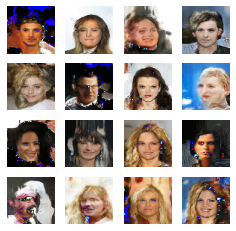

Time for epoch 65 is 393.0431237220764 sec
Time for epoch 66 is 395.67599964141846 sec
Time for epoch 67 is 392.26300144195557 sec
Time for epoch 68 is 392.18999910354614 sec
Time for epoch 69 is 392.1950011253357 sec


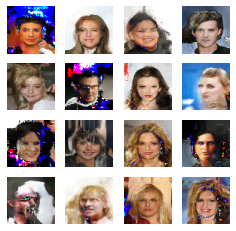

Time for epoch 70 is 392.97017908096313 sec
Time for epoch 71 is 392.5559997558594 sec
Time for epoch 72 is 392.6550054550171 sec
Time for epoch 73 is 392.89899706840515 sec
Time for epoch 74 is 392.992999792099 sec


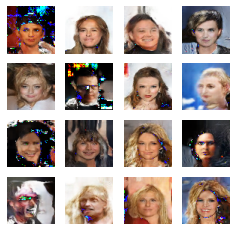

Time for epoch 75 is 394.31443762779236 sec
Time for epoch 76 is 393.0309987068176 sec
Time for epoch 77 is 392.8900010585785 sec
Time for epoch 78 is 393.0009994506836 sec
Time for epoch 79 is 392.91400027275085 sec


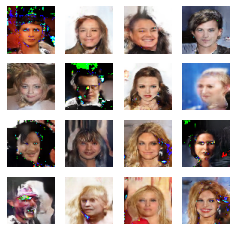

Time for epoch 80 is 394.18459248542786 sec
Time for epoch 81 is 393.0109989643097 sec
Time for epoch 82 is 393.0940001010895 sec
Time for epoch 83 is 393.143000125885 sec
Time for epoch 84 is 392.1010003089905 sec


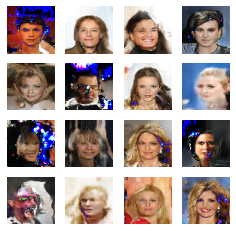

Time for epoch 85 is 392.7878119945526 sec
Time for epoch 86 is 395.02165603637695 sec
Time for epoch 87 is 394.634557723999 sec
Time for epoch 88 is 396.7967119216919 sec
Time for epoch 89 is 393.5 sec


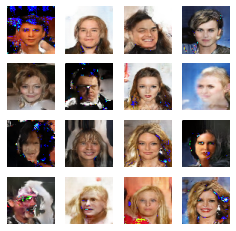

Time for epoch 90 is 394.12758803367615 sec
Time for epoch 91 is 393.7309982776642 sec
Time for epoch 92 is 392.9709994792938 sec
Time for epoch 93 is 392.9830026626587 sec
Time for epoch 94 is 393.4950032234192 sec


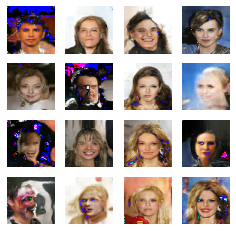

Time for epoch 95 is 394.1491479873657 sec
Time for epoch 96 is 393.0129990577698 sec
Time for epoch 97 is 393.0090003013611 sec
Time for epoch 98 is 393.44300055503845 sec
Time for epoch 99 is 392.90500116348267 sec


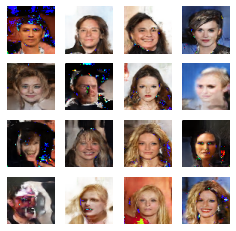

Time for epoch 100 is 393.42979621887207 sec


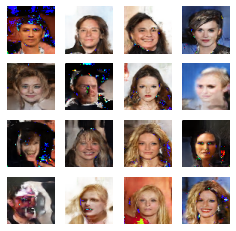

Wall time: 10h 54min 20s


In [15]:
%%time
train(train_dataset, EPOCHS)